# CONFLUENCE Tutorial 1b — Point-Scale Workflow (FLUXNET CA-NS7)

## Introduction
This notebook mirrors the concise, configuration-first style established in **Tutorial 01a** and adapts it for **energy-balance validation at a FLUXNET tower (CA-NS7)**. We simulate point-scale land–atmosphere exchanges and evaluate **evapotranspiration (LE)** and **sensible heat (H)** using FLUXNET observations.

The workflow is strictly configuration-driven and fully reproducible:
1) write a minimal config, 2) initialize CONFLUENCE and standard project layout, 3) define the point-scale domain, 4) acquire & preprocess inputs, 5) run **SUMMA**, and 6) evaluate fluxes.


# Step 1 — Configuration (pick or generate)

We start by generating a compact configuration for the **CA-NS7** FLUXNET site using the same pattern as 01a. This keeps initialization a one-liner and the workflow fully reproducible.

In [1]:
# Step 1 — Create a site-specific configuration for the CA-NS7 FLUXNET example
from pathlib import Path
import yaml

# Path to the default template configuration (same pattern as 01a)
config_template = Path("../../0_config_files/config_template.yaml")

# Load the base configuration
with open(config_template, "r") as f:
    config = yaml.safe_load(f)

# === Modify key entries for the CA-NS7 point-scale case ===
# Code & data directories
config["CONFLUENCE_CODE_DIR"] = str(Path("../../").resolve())
#config["CONFLUENCE_DATA_DIR"] = str(Path("/path/to/CONFLUENCE_data").resolve())

# Point-scale domain settings
config["DOMAIN_DEFINITION_METHOD"] = "point"
config["DOMAIN_DISCRETIZATION"] = "GRUs"  # 1 GRU => 1 HRU
config["DOMAIN_NAME"] = "CA-NS7"
config["POUR_POINT_COORDS"] = "56.6358/-99.9483"  # CA-NS7 coordinates
config["BOUNDING_BOX_COORDS"] = "56.6858/-99.9983/56.585800000000006/-99.8983"


# Data/forcing & model
config["HYDROLOGICAL_MODEL"] = "SUMMA"
config["FORCING_DATASET"] = "ERA5"  # Used for meteorological inputs
config["DOWNLOAD_FLUXNET"] = True
config["FLUXNET_STATION"] = "CA-NS7"

# Define the temporal extent of the experiment
config["EXPERIMENT_TIME_START"] = "2001-01-01 01:00"
config["EXPERIMENT_TIME_END"] = "2005-12-31 23:00"
config['CALIBRATION_PERIOD'] = "2002-10-01, 2003-09-30"
config['EVALUATION_PERIOD'] = "2003-10-01, 2004-09-30"
config['SPINUP_PERIOD'] = "2001-01-01, 2002-09-30"

# (Optional) Paths to institutional data roots — customize if using shared infra
config['DATATOOL_DATASET_ROOT'] = '/path/to/meteorological-data/'
config['GISTOOL_DATASET_ROOT']  = '/path/to/geospatial-data/'
config['TOOL_CACHE']            = '/path/to/cache/dir'
config['CLUSTER_JSON']          = '/path/to/cluster.json'

# Basic optimization knobs if desired (example only)
config['PARAMS_TO_CALIBRATE'] = 'minStomatalResistance,cond2photo_slope,vcmax25_canopyTop,jmax25_scale,summerLAI,rootingDepth,soilStressParam,z0Canopy,windReductionParam'
config['OPTIMISATION_TARGET'] = 'et'
config['ITERATIVE_OPTIMIZATION_ALGORITHM'] = 'DDS'
config['OPTIMIZATION_METRIC'] = 'RMSE'
config['CALIBRATION_TIMESTEP'] = 'daily'  

# Unique experiment ID for outputs
config["EXPERIMENT_ID"] = "run_fluxnet_1"

# === Save the customized configuration ===
out_config = Path("../../0_config_files/config_fluxnet_CA-NS7.yaml")
with open(out_config, "w") as f:
    yaml.dump(config, f, default_flow_style=False, sort_keys=False)

print(f"✅ New configuration written to: {out_config}")

✅ New configuration written to: ../../0_config_files/config_fluxnet_CA-NS7.yaml


## Step 1b — Initialize CONFLUENCE
Initialize the framework using the configuration prepared above.

In [2]:
# Step 1b — Initialize CONFLUENCE
import os, sys
sys.path.append(os.path.abspath(os.path.join("..", "..")))
from CONFLUENCE import CONFLUENCE  # adjust if your import path differs

config_path = "../../0_config_files/config_fluxnet_CA-NS7.yaml"
confluence = CONFLUENCE(config_path)

print("✅ CONFLUENCE initialized successfully.")
print(f"Configuration loaded from: {config_path}")

2025-11-08 11:24:38 ● CONFLUENCE Logging Initialized
2025-11-08 11:24:38 ● Domain: CA-NS7
2025-11-08 11:24:38 ● Experiment ID: run_fluxnet_1
2025-11-08 11:24:38 ● Log Level: INFO
2025-11-08 11:24:38 ● Log File: /Users/darrieythorsson/compHydro/test/CONFLUENCE_data/domain_CA-NS7/_workLog_CA-NS7/confluence_general_CA-NS7_20251108_112438.log
2025-11-08 11:24:38 ● Configuration logged to: /Users/darrieythorsson/compHydro/test/CONFLUENCE_data/domain_CA-NS7/_workLog_CA-NS7/config_CA-NS7_20251108_112438.yaml
2025-11-08 11:24:38 ● CONFLUENCE initialized with config: ../../0_config_files/config_fluxnet_CA-NS7.yaml
2025-11-08 11:24:38 ● Creating point domain shapefile from bounding box coordinates
2025-11-08 11:24:38 ● Point domain shapefile created successfully: /Users/darrieythorsson/compHydro/test/CONFLUENCE_data/domain_CA-NS7/shapefiles/river_basins/CA-NS7_riverBasins_point.shp
2025-11-08 11:24:38 ● Bounding box: lat_min=56.585800000000006, lat_max=56.6858, lon_min=-99.9983, lon_max=-99.8983

## Step 1c — Project structure setup
Create the standardized project directory and a pour-point feature for the site.

In [3]:
# Step 1c — Project structure setup
from pathlib import Path

# 1) Create the standardized project layout (logs, config link, data/output folders, etc.)
project_dir = confluence.managers['project'].setup_project()

# 2) Create a pour-point feature (site reference geometry for point-scale workflows)
pour_point_path = confluence.managers['project'].create_pour_point()

print("✅ Project structure created.")
print(f"Project root: {project_dir}")
print(f"Pour point:   {pour_point_path}")

# 3) Brief top-level directory preview
print("\nTop-level structure:")
for p in sorted(Path(project_dir).iterdir()):
    if p.is_dir():
        print(f"├── {p.name}")

2025-11-08 11:24:39 ● Setting up project for domain: CA-NS7
2025-11-08 11:24:39 ● Project directory created at: /Users/darrieythorsson/compHydro/test/CONFLUENCE_data/domain_CA-NS7
2025-11-08 11:24:39 ● Pour point shapefile created successfully: /Users/darrieythorsson/compHydro/test/CONFLUENCE_data/domain_CA-NS7/shapefiles/pour_point/CA-NS7_pourPoint.shp
✅ Project structure created.
Project root: /Users/darrieythorsson/compHydro/test/CONFLUENCE_data/domain_CA-NS7
Pour point:   /Users/darrieythorsson/compHydro/test/CONFLUENCE_data/domain_CA-NS7/shapefiles/pour_point/CA-NS7_pourPoint.shp

Top-level structure:
├── _workLog_CA-NS7
├── attributes
├── forcing
├── observations
├── optimisation
├── plots
├── settings
├── shapefiles
├── simulations


# Step 2 — Domain definition (point-scale GRU)
The domain is a **single GRU** around the flux tower footprint, ensuring a strictly point-scale (non-routed) experiment.

### Step 2a — Geospatial attribute acquisition

In [4]:
# Step 2a — Acquire attributes (model-agnostic)
#confluence.managers['data'].acquire_attributes()
print("✅ Attribute acquisition complete")

✅ Attribute acquisition complete


### Step 2b — Domain definition (point-scale)
Define a minimal footprint around **CA-NS7** consistent with the pour point.

In [5]:
# Step 2b — Define the point-scale domain
watershed_path = confluence.managers['domain'].define_domain()
print("✅ Domain definition complete")
print(f"Domain file: {watershed_path}")

2025-11-08 11:24:39 ● Domain definition workflow starting with: point
2025-11-08 11:24:39 ● Point domain shapefile already exists: /Users/darrieythorsson/compHydro/test/CONFLUENCE_data/domain_CA-NS7/shapefiles/river_basins/CA-NS7_riverBasins_point.shp
2025-11-08 11:24:39 ● Domain definition completed using method: point
2025-11-08 11:24:39 ● Domain map saved to /Users/darrieythorsson/compHydro/test/CONFLUENCE_data/domain_CA-NS7/plots/domain/domain_map.png
2025-11-08 11:24:39 ● Domain definition workflow finished
✅ Domain definition complete
Domain file: /Users/darrieythorsson/compHydro/test/CONFLUENCE_data/domain_CA-NS7/shapefiles/river_basins/CA-NS7_riverBasins_point.shp


### Step 2c — Discretization (required even for 1 GRU = 1 HRU)
Creates the **catchment HRU** artifacts required by downstream steps (still 1:1 with the GRU for point scale).

In [6]:
# Step 2c — Discretization (GRUs → HRUs 1:1)
hru_path = confluence.managers['domain'].discretize_domain()
print("✅ Domain discretization complete")
print(f"HRU file: {hru_path}")

2025-11-08 11:24:39 ● Discretizing domain using method: GRUs
2025-11-08 11:24:39 ● Starting domain discretization using attributes: ['GRUs']
Step 1/2: Running single attribute discretization method
2025-11-08 11:24:39 ● config domain name CA-NS7
2025-11-08 11:24:39 ● Calculating mean elevation for each HRU
2025-11-08 11:24:39 ● DEM CRS: EPSG:4326
2025-11-08 11:24:39 ● Shapefile CRS: EPSG:4326
2025-11-08 11:24:39 ● CRS match - no reprojection needed
2025-11-08 11:24:39 ● Successfully calculated elevation statistics for 1 HRUs
2025-11-08 11:24:39 ● Calculated centroids in WGS84: lat range 56.635788 to 56.635788, lon range -99.948300 to -99.948300
2025-11-08 11:24:39 ● GRUs saved as HRUs to /Users/darrieythorsson/compHydro/test/CONFLUENCE_data/domain_CA-NS7/shapefiles/catchment/CA-NS7_HRUs_GRUs.shp
2025-11-08 11:24:39 ● HRU plot saved to /Users/darrieythorsson/compHydro/test/CONFLUENCE_data/domain_CA-NS7/plots/catchment/CA-NS7_HRUs_as_GRUs.png
Step 2/2: Sorting catchment shape
2025-11-08 

## Step 2d — Verification & inspection (CA-NS7)
We verify the expected shapefiles in standardized locations, then draw a minimal GRU–HRU overlay.

✅ GRU file found: /Users/darrieythorsson/compHydro/test/CONFLUENCE_data/domain_CA-NS7/shapefiles/river_basins/CA-NS7_riverBasins_point.shp
✅ HRU file found: /Users/darrieythorsson/compHydro/test/CONFLUENCE_data/domain_CA-NS7/shapefiles/catchment/CA-NS7_HRUs_GRUs.shp


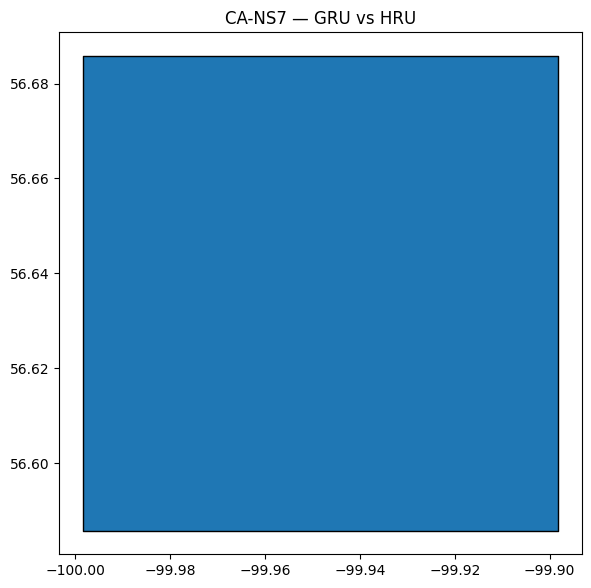

In [7]:
# Step 2d — Verify domain outputs and inspect geometry
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import yaml

# 1) Read config to derive data & domain paths
with open("../../0_config_files/config_fluxnet_CA-NS7.yaml") as f:
    cfg = yaml.safe_load(f)

data_dir   = Path(cfg["CONFLUENCE_DATA_DIR"])
domain_dir = data_dir / f"domain_{cfg['DOMAIN_NAME']}"
shp_dir    = domain_dir / "shapefiles"

# 2) Explicit expected shapefiles for CA-NS7
gru_fp = shp_dir / "river_basins" / f"{cfg['DOMAIN_NAME']}_riverBasins_point.shp"
hru_fp = shp_dir / "catchment"     / f"{cfg['DOMAIN_NAME']}_HRUs_GRUs.shp"

# 3) Verify presence
for label, path in [("GRU", gru_fp), ("HRU", hru_fp)]:
    if not path.exists():
        raise FileNotFoundError(f"❌ Expected {label} file not found: {path}")
    print(f"✅ {label} file found: {path}")

# 4) Minimal overlay plot
gru = gpd.read_file(gru_fp)
hru = gpd.read_file(hru_fp)
if hru.crs != gru.crs:
    hru = hru.to_crs(gru.crs)
ax = gru.plot(figsize=(6, 6))
hru.plot(ax=ax, facecolor="none")
ax.set_title("CA-NS7 — GRU vs HRU")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

# Step 3 — Input preprocessing (model-agnostic)
We prepare inputs in three small moves: 1) acquire **meteorological forcings**, 2) process **FLUXNET observations**, and 3) run **model-agnostic preprocessing** to standardize variables and time steps.

### Step 3a — Acquire meteorological forcings (ERA5)

In [8]:
# Step 3a — Forcings
#confluence.managers['data'].acquire_forcings()
print("✅ Forcing data acquisition complete")

✅ Forcing data acquisition complete


### Step 3b — Process observations (FLUXNET)

In [9]:
# Step 3b — Observations
#confluence.managers['data'].process_observed_data()
print("✅ FLUXNET observational data processing complete")

✅ FLUXNET observational data processing complete


### Step 3c — Model-agnostic preprocessing

In [10]:
# Step 3c — Model-agnostic preprocessing
confluence.managers['data'].run_model_agnostic_preprocessing()
print("✅ Model-agnostic preprocessing complete")

2025-11-08 11:24:39 ● Starting model-agnostic preprocessing
2025-11-08 11:24:39 ● Running geospatial statistics
2025-11-08 11:24:39 ● Starting geospatial statistics calculation
2025-11-08 11:24:39 ● Soil statistics already calculated: /Users/darrieythorsson/compHydro/test/CONFLUENCE_data/domain_CA-NS7/shapefiles/catchment_intersection/with_soilgrids/catchment_with_soilclass.shp
2025-11-08 11:24:39 ● Land statistics already calculated: /Users/darrieythorsson/compHydro/test/CONFLUENCE_data/domain_CA-NS7/shapefiles/catchment_intersection/with_landclass/catchment_with_landclass.shp
2025-11-08 11:24:39 ● Elevation statistics already calculated: /Users/darrieythorsson/compHydro/test/CONFLUENCE_data/domain_CA-NS7/shapefiles/catchment_intersection/with_dem/catchment_with_dem.shp
2025-11-08 11:24:39 ● Geospatial statistics completed: 3/3 steps skipped, 0/3 steps executed
2025-11-08 11:24:39 ● Running forcing resampling
2025-11-08 11:24:39 ● Starting forcing data resampling process
2025-11-08 11

### Step 3d — Quick verification
Confirm the expected folders exist and contain files (derived from configuration; no hard-coded paths).

In [11]:
from pathlib import Path
import yaml

with open("../../0_config_files/config_fluxnet_CA-NS7.yaml") as f:
    cfg = yaml.safe_load(f)

data_dir   = Path(cfg["CONFLUENCE_DATA_DIR"])
domain_dir = data_dir / f"domain_{cfg['DOMAIN_NAME']}"

targets = {
    "forcing/raw_data":                        domain_dir / "forcing" / "raw_data",
    "forcing/basin_averaged_data":             domain_dir / "forcing" / "basin_averaged_data",
}

def count_files(p: Path) -> int:
    return sum(1 for x in p.iterdir() if x.is_file()) if p.exists() else 0

for label, path in targets.items():
    exists = path.exists()
    n = count_files(path)
    status = "✅" if exists and n > 0 else ("⚠️ empty" if exists else "❌ missing")
    suffix = f"({n} files)" if exists else ""
    print(f"{status} {label}  {suffix}")

✅ forcing/raw_data  (73 files)
✅ forcing/basin_averaged_data  (72 files)


# Step 4 — Model-specific preprocessing & model run (SUMMA)

### Step 4a — SUMMA-specific preprocessing

In [ ]:
# Step 4a — SUMMA-specific preprocessing
confluence.managers['model'].preprocess_models()
print("✅ Model-specific preprocessing complete")

2025-11-08 11:24:39 ● Starting model-specific preprocessing
2025-11-08 11:24:39 ● Starting SUMMA spatial preprocessing
2025-11-08 11:24:39 ● Starting memory-efficient temperature lapse rate and data step application
2025-11-08 11:24:39 ● Loading topology data...
2025-11-08 11:24:39 ● Loaded topology data: 2 rows, 0.00 MB
2025-11-08 11:24:39 ● Found 72 forcing files to process
2025-11-08 11:24:39 ● Pre-calculating lapse rate corrections...
2025-11-08 11:24:39 ● Prepared lapse corrections for 1 HRUs
2025-11-08 11:24:39 ● Processing files in batches of 72


## Step 4b — Instantiate & run the model

In [ ]:
# Step 4b — Instantiate & run SUMMA
print(f"Running {confluence.config['HYDROLOGICAL_MODEL']} for point-scale simulation…")
confluence.managers['model'].run_models()
print("✅ Point-scale model run complete")

### Step 4c — Quick verification
Print where SUMMA inputs and run outputs were written (paths are derived from the configuration).

In [ ]:
from pathlib import Path
import yaml

with open("../../0_config_files/config_fluxnet_CA-NS7.yaml") as f:
    cfg = yaml.safe_load(f)

data_dir   = Path(cfg["CONFLUENCE_DATA_DIR"])
domain_dir = data_dir / f"domain_{cfg['DOMAIN_NAME']}"

# Common locations used by the model manager
summa_in   = domain_dir / "forcing" / "SUMMA_input"
results    = domain_dir / "simulations" / cfg['EXPERIMENT_ID'] / 'SUMMA'

print("SUMMA input dir:", summa_in if summa_in.exists() else "(not found)")
print("Results dir:",    results if results.exists()    else "(not found)")

# Step 5 — ET & H Validation (FLUXNET vs Simulation)
We compute basic metrics and draw quick comparisons between **observed** and **simulated** latent heat/ET and sensible heat. The code is resilient to different variable names in SUMMA outputs.

In [ ]:
# Step 5 — ET & H Validation (FLUXNET vs Simulation) — robust time handling + 1D-safe

from pathlib import Path
import yaml, pandas as pd, numpy as np, xarray as xr
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta

# --- Paths from config ---
with open("../../0_config_files/config_fluxnet_CA-NS7.yaml") as f:
    cfg = yaml.safe_load(f)

data_dir   = Path(cfg["CONFLUENCE_DATA_DIR"])
domain_dir = data_dir / f"domain_{cfg['DOMAIN_NAME']}"

# ===== Helpers =================================================================

def find_time_coord(ds: xr.Dataset) -> str:
    """Find a time-like coordinate/dimension name in ds."""
    # exact match first
    if "time" in ds.coords or "time" in ds.dims:
        return "time"
    # any coord containing 'time'
    for c in list(ds.coords) + list(ds.dims):
        if re.search(r"time", c, re.I):
            return c
    # look for 1D datetime-like variables
    for name, var in ds.variables.items():
        if var.ndim == 1 and re.search(r"time", name, re.I):
            return name
    raise KeyError("No time-like coordinate found in dataset.")

def parse_spinup_end(cfg_dict) -> datetime | None:
    """Parse SPINUP_PERIOD like 'YYYY-MM-DD, YYYY-MM-DD' and return the end date (+1 day)."""
    s = cfg_dict.get("SPINUP_PERIOD", "")
    if not s or "," not in s:
        return None
    try:
        start_s, end_s = [x.strip() for x in s.split(",")]
        end_dt = pd.to_datetime(end_s).to_pydatetime()
        return end_dt + timedelta(days=1)
    except Exception:
        return None

def reduce_to_time_series(da: xr.DataArray, time_dim: str) -> xr.DataArray:
    """
    Ensure da -> 1D over time_dim:
      1) .squeeze(drop=True) to remove size-1 dims,
      2) if still has extra dims besides time_dim, average over them.
    Returns an xarray DataArray with dims (time_dim,).
    """
    da = da.squeeze(drop=True)
    # rename time-like to time_dim if needed
    if time_dim not in da.dims:
        # try swapping a coordinate that equals time_dim
        for d in da.dims:
            if d.lower() == time_dim.lower():
                da = da.rename({d: time_dim})
                break
    if time_dim not in da.dims:
        # Final fallback if time is a coord not a dim
        if time_dim in da.coords and da.dims:
            da = da.swap_dims({da.dims[0]: time_dim})
        else:
            raise ValueError(f"Variable lacks a '{time_dim}' dimension: dims={da.dims}")
    other_dims = [d for d in da.dims if d != time_dim]
    if other_dims:
        da = da.mean(dim=other_dims, skipna=True)
    return da

def to_series_time1d(da: xr.DataArray, time_dim: str) -> pd.Series:
    """Convert to 1D time series safely."""
    da1 = reduce_to_time_series(da, time_dim)
    # direct to_series may create multiindex if coords linger; rebuild index explicitly
    idx = pd.to_datetime(da1[time_dim].values)
    return pd.Series(da1.values, index=idx)

def pick_var(candidates, ds_vars):
    """Return the first candidate present in ds_vars (set/list)."""
    return next((v for v in candidates if v in ds_vars), None)

# ===== Open dataset & choose evaluation window =================================

# Find a daily SUMMA output (e.g., *_day.nc) under the domain folder
nc_files = list(domain_dir.rglob("*_day.nc"))
if not nc_files:
    raise FileNotFoundError("No daily netCDF found (pattern '*_day.nc').")
nc_path = nc_files[0]

ds = xr.open_dataset(nc_path)
time_dim = find_time_coord(ds)

# Prefer config SPINUP_PERIOD end as the slice start; fallback to min-year + 1
start_dt_cfg = parse_spinup_end(cfg)
if start_dt_cfg is None:
    # fallback: use first valid time + 1 year
    if ds[time_dim].size == 0:
        raise ValueError("Dataset has zero-length time dimension.")
    t0 = pd.to_datetime(ds[time_dim].values[0]).to_pydatetime()
    start_dt_cfg = datetime(t0.year + 1, 1, 1)

ds_eval = ds
try:
    ds_eval = ds.sel({time_dim: slice(start_dt_cfg, None)})
    if ds_eval[time_dim].size == 0:
        # if slice produced empty set, keep the full ds
        print("⚠️ Time slice after SPINUP produced no data; using full dataset.")
        ds_eval = ds
except Exception:
    print("⚠️ Could not slice by time; using full dataset.")
    ds_eval = ds

# ===== Candidate lists =========================================================

# ET or LE (LE will be converted to ET)
le_candidates = ["Qle", "qle", "latentHeatFlux", "scalarLatHeatTotal", "LE_sim", "LE"]
et_candidates = ["ET", "evapotranspiration", "evspsbl", "tEvap", "et_mm_day"]

# Sensible heat H
h_candidates  = ["Qh", "qh", "sensibleHeatFlux", "H_sim", "H"]

# For energy balance fallback: Rn - G - LE
rn_candidates = [
    "scalarNetRadiation", "netRadiation", "Qnet", "RNET_sim", "Rnet_sim", "Rn", "Rn_surface"
]
g_candidates  = ["groundHeatFlux", "Qg", "qg", "G_sim", "G"]

ds_vars = set(list(ds_eval.data_vars))

# ===== ET/LE from simulation ===================================================

le_var = pick_var(le_candidates, ds_vars)
et_var = pick_var(et_candidates, ds_vars)

if et_var is None and le_var is None:
    # regex sweep for odd names
    le_var = next((v for v in ds_vars if re.search(r"\b(le|latent)\b", v, re.I)), None)
    et_var = next((v for v in ds_vars if re.search(r"\bet\b|evap", v, re.I)), None)

if et_var is None and le_var is not None:
    # Convert LE (W/m^2) -> ET (mm/day)
    et_series_sim = -to_series_time1d(ds_eval[le_var], time_dim) * 0.0353
elif et_var is not None:
    et_series_sim = -to_series_time1d(ds_eval[et_var], time_dim)
else:
    raise KeyError(
        f"Could not find ET or LE variables. "
        f"Tried ET {et_candidates} and LE {le_candidates} (and regex fallbacks)."
    )

# ===== H from simulation: direct var OR fallback from energy balance ===========
h_var = pick_var(h_candidates, ds_vars)
if h_var is not None:
    h_series_sim = to_series_time1d(ds_eval[h_var], time_dim)
else:
    # Fallback: H ≈ Rn - G - LE   (use LE in W/m^2; if we only have ET, convert back)
    rn_var = pick_var(rn_candidates, ds_vars)
    g_var  = pick_var(g_candidates,  ds_vars)

    rn_ok = rn_var is not None
    g_ok  = g_var  is not None

    # Need a W/m^2 latent heat series for fallback
    if le_var is not None:
        le_wm2_series = to_series_time1d(ds_eval[le_var], time_dim)
    else:
        # Convert ET back to LE (mm/day -> W/m^2) using inverse of 0.0353
        le_wm2_series = et_series_sim / 0.0353

    if rn_ok and g_ok:
        rn_series = to_series_time1d(ds_eval[rn_var], time_dim)
        g_series  = to_series_time1d(ds_eval[g_var],  time_dim)

        # Align to common index
        idx = rn_series.index
        common_idx = idx.intersection(g_series.index).intersection(le_wm2_series.index)
        if len(common_idx) == 0:
            h_series_sim = None
        else:
            rn_a = rn_series.loc[common_idx].astype(float)
            g_a  = g_series.loc[common_idx].astype(float)
            le_a = le_wm2_series.loc[common_idx].astype(float)
            h_series_sim = (rn_a - g_a - le_a)
    else:
        h_series_sim = None  # No sensible heat estimate possible

# ===== Load FLUXNET observations (processed) ==================================

proc_dir = domain_dir / "observations" / "energy_fluxes" / "processed"
cand = sorted(proc_dir.rglob("*.csv"))
if not cand:
    raise FileNotFoundError(f"No processed FLUXNET CSV found under: {proc_dir}")
obs_path = cand[0]
obs = pd.read_csv(obs_path)

# Make a timestamp; try common names or TIMESTAMP_START
ts_col = next((c for c in obs.columns if re.search(r"timestamp|time|date", c, re.I)), None)
if ts_col is None and "TIMESTAMP_START" in obs.columns:
    obs["timestamp"] = pd.to_datetime(
        obs["TIMESTAMP_START"].astype(str), format="%Y%m%d%H%M", errors="coerce"
    )
    ts_col = "timestamp"
elif ts_col is not None:
    obs[ts_col] = pd.to_datetime(obs[ts_col])
else:
    raise KeyError("Could not find a timestamp column in processed FLUXNET data.")

obs = obs.dropna(subset=[ts_col]).set_index(ts_col).sort_index()

# Observation variables: LE and H
le_obs_candidates = ["LE_F_MDS", "LE", "ET_from_LE_mm_per_day"]
h_obs_candidates  = ["H_F_MDS", "H"]

def first_available(cols, df):
    for c in cols:
        if c in df.columns:
            return c
    return None

le_obs_col = first_available(le_obs_candidates, obs)
h_obs_col  = first_available(h_obs_candidates,  obs)

if le_obs_col is None:
    raise KeyError(f"Missing expected FLUXNET LE column. Tried {le_obs_candidates}")

# Convert LE (W/m^2) to ET (mm/day) if needed
if le_obs_col in ("LE_F_MDS", "LE"):
    obs["ET_obs_mm_day"] = obs[le_obs_col] * 0.0353
elif le_obs_col == "ET_from_LE_mm_per_day":
    obs["ET_obs_mm_day"] = obs[le_obs_col]
else:
    obs["ET_obs_mm_day"] = obs[le_obs_col] * 0.0353

# Daily aggregation for obs (if higher frequency)
obs_daily = obs.resample("1D").mean(numeric_only=True)
et_obs_series = obs_daily["ET_obs_mm_day"].dropna()
h_obs_series  = obs_daily[h_obs_col].dropna() if h_obs_col in obs_daily.columns else None

# ===== Metrics & plots =========================================================

def align(a: pd.Series, b: pd.Series):
    idx = a.index.intersection(b.index)
    a2 = pd.Series(a, index=idx).astype(float)
    b2 = pd.Series(b, index=idx).astype(float)
    return a2, b2

def rmse(a, b):
    d = (a - b).to_numpy(dtype=float)
    return float(np.sqrt(np.nanmean(d**2)))

def bias(a, b):
    return float((a - b).mean())

def corr(a, b):
    return float(pd.Series(a).corr(pd.Series(b)))

# Compute ET metrics
et_sim_a, et_obs_a = align(et_series_sim, et_obs_series)
et_metrics = dict(RMSE=round(rmse(et_sim_a, et_obs_a), 3),
                  Bias=round(bias(et_sim_a, et_obs_a), 3),
                  r=round(corr(et_sim_a, et_obs_a), 3))
print("ET metrics:", et_metrics)

# Compute H metrics only if we have both obs and sim
h_metrics = None
h_sim_a = h_obs_a = None
if h_series_sim is not None and h_obs_series is not None:
    h_sim_a, h_obs_a = align(h_series_sim, h_obs_series)
    if len(h_sim_a) > 0:
        h_metrics = dict(RMSE=round(rmse(h_sim_a, h_obs_a), 3),
                         Bias=round(bias(h_sim_a, h_obs_a), 3),
                         r=round(corr(h_sim_a, h_obs_a), 3))
        print("H  metrics:", h_metrics)
    else:
        print("H metrics: (no overlapping dates)")

# --- Plots ---
if h_metrics is None:
    # ET-only figure if H is unavailable
    plt.figure(figsize=(9, 4))
    plt.plot(et_obs_a.index, et_obs_a.values, label="ET obs (mm/d)")
    plt.plot(et_sim_a.index, et_sim_a.values, label="ET sim (mm/d)")
    plt.ylabel("mm/day")
    plt.title("Evapotranspiration")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ET scatter
    plt.figure(figsize=(5, 4))
    plt.scatter(et_obs_a, et_sim_a, s=6)
    plt.xlabel("ET obs (mm/d)")
    plt.ylabel("ET sim (mm/d)")
    plt.title(f"ET (r={et_metrics['r']})")
    plt.tight_layout()
    plt.show()
else:
    # Time series (ET & H)
    fig, axes = plt.subplots(2, 1, figsize=(9, 6), sharex=True)
    axes[0].plot(et_obs_a.index, et_obs_a.values, label="ET obs (mm/d)")
    axes[0].plot(et_sim_a.index, et_sim_a.values, label="ET sim (mm/d)")
    axes[0].set_ylabel("mm/day")
    axes[0].set_title("Evapotranspiration")
    axes[0].legend()

    axes[1].plot(h_obs_a.index, h_obs_a.values, label="H obs (W/m²)")
    axes[1].plot(h_sim_a.index, h_sim_a.values, label="H sim (W/m²)")
    axes[1].set_ylabel("W m$^{-2}$")
    axes[1].set_title("Sensible Heat Flux")
    axes[1].legend()
    plt.tight_layout()
    plt.show()

    # Scatter quick skill view
    fig2, axes2 = plt.subplots(1, 2, figsize=(10, 4))
    axes2[0].scatter(et_obs_a, et_sim_a, s=6)
    axes2[0].set_xlabel("ET obs (mm/d)")
    axes2[0].set_ylabel("ET sim (mm/d)")
    axes2[0].set_title(f"ET (r={et_metrics['r']})")

    axes2[1].scatter(h_obs_a, h_sim_a, s=6)
    axes2[1].set_xlabel("H obs (W/m²)")
    axes2[1].set_ylabel("H sim (W/m²)")
    axes2[1].set_title(f"H (r={h_metrics['r']})")
    plt.tight_layout()
    plt.show()


In [ ]:
# Step 5b — Run calibration 

results_file = confluence.managers['optimization'].calibrate_model()  
print("Calibration results file:", results_file)